In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_VII"
plane = "V"

In [12]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -40 and x - mu_x[0] < 40:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
#  construct the transport matrix when only drift between grids!
    # See slide 21 of https://cas.web.cern.ch/cas/France-2008/Lectures/Braun-Emittance.pdf
    
    # The distance between the grids is 2.500 according to layout
    # They have been corrected according to the survey measurements. Minimal impact anyway
    La = 0.000;      # m
    Lb = La + 2.485; # m
    Lc = Lb + 2.487; # m

    Row_1 = [1, -2*La, La**2];
    Row_2 = [1, -2*Lb, Lb**2];
    Row_3 = [1, -2*Lc, Lc**2];

    # Create the matrix M
    M = np.matrix( [Row_1, Row_2, Row_3]) 
    x = [sigma_grid_1**2, sigma_grid_2**2, sigma_grid_3**2]

    # left for reference
    # inverse of M
    # print M.I
    #print linalg.solve(A, x)     # Solve the linear equation system.
    
    ## output vector
    out = np.linalg.solve(M, x)

    # twiss parameters
    beta_x_emitRMS  = out[0]
    alpha_x_emitRMS = out[1]
    gamma_x_emitRMS = out[2]

    # RMS Emittance
    emitRMS = np.sqrt(beta_x_emitRMS*gamma_x_emitRMS - alpha_x_emitRMS**2)

    # Normalized Emittance
    emittance_semgrid = emitRMS * beta_rel * gamma_rel
    print(">>> SEMGRID emittance", emittance_semgrid)

    # twiss parameter
    betaTwiss  = beta_x_emitRMS / emitRMS
    alphaTwiss = alpha_x_emitRMS/ emitRMS
    emittance_wire = ((sigma_wire)**2 / 4.22) * beta_rel * gamma_rel
    norm_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", emittance_wire, np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity)
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
        sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [13]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results_new")

# result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
result_folders.remove('data.txt')
result_folders.remove('emittance.png')
# result_folders.remove('plots.pdf')

print(result_folders)

['PROFILE_320_V_R3_2018_10_30_17_42', 'PROFILE_300_V_R3_2018_10_30_17_34', 'PROFILE_310_V_R3_2018_10_30_17_39']



PROFILE_320_V_R3_2018_10_30_17_42


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


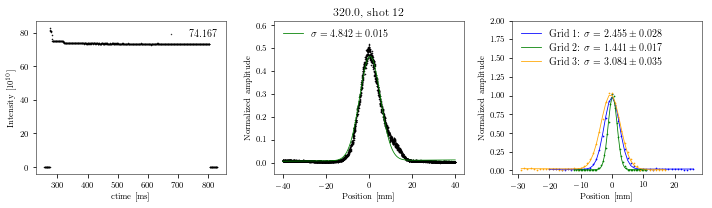

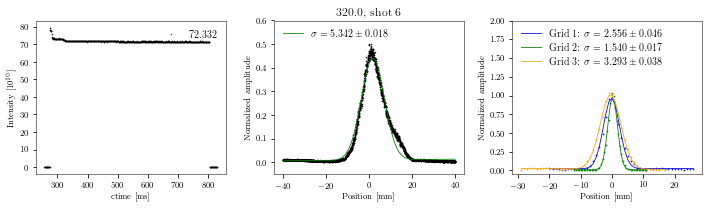

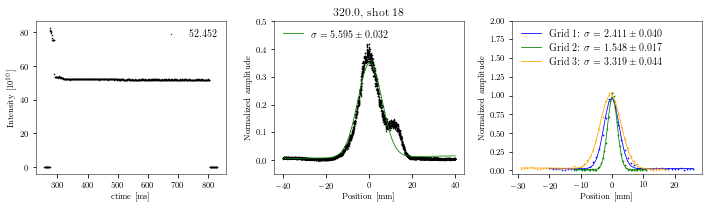

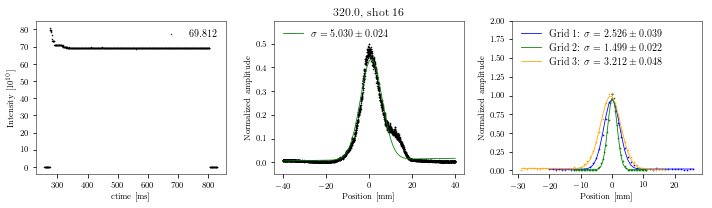

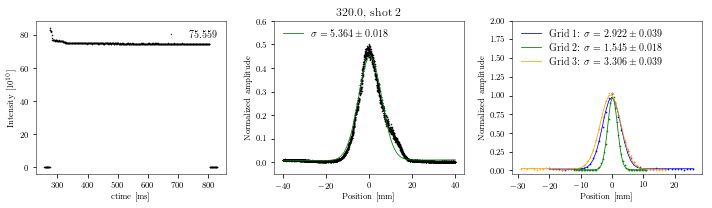

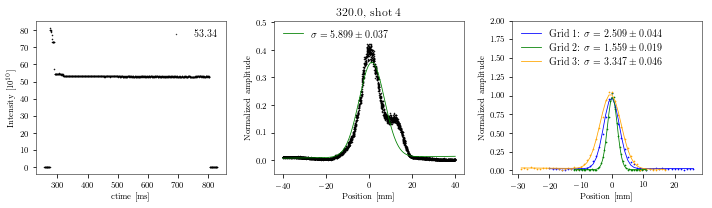

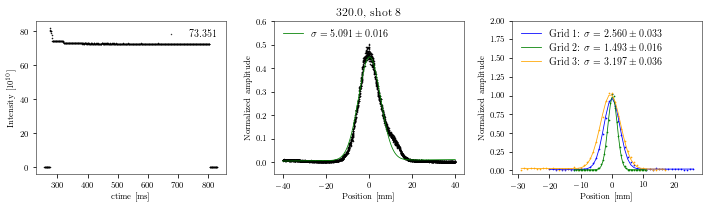

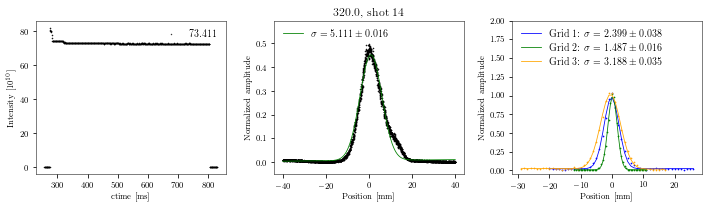

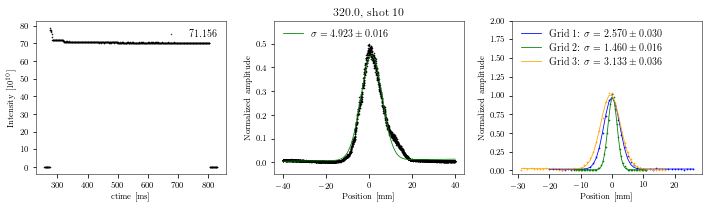

Recorded intensities: [ 74.167  72.332  52.452  69.812  75.559  53.34   73.351  73.411  71.156]
Intensities after outlier exclusion: [74.167000000000002, 72.332000000000008, 0, 69.811999999999998, 75.558999999999997, 0, 73.350999999999999, 73.411000000000001, 71.156000000000006]
Beta wire: 3.9188318840500003
Beta rel: 0.37581 Gamma rel: 1.0791
>>> SEMGRID emittance [ 0.54245192  0.60654407  0.5820104   0.58237597  0.67610822  0.60739158
  0.58551945  0.55308706  0.57244734]
2.25264868229 74.167
2.74284281596 72.332
3.008603162 0
An intensity value was excluded.
2.43136046847 69.812
2.76453800453 75.559
3.3444996275 0
An intensity value was excluded.
2.49049400079 73.351
2.51053992528 73.411
2.32936713833 71.156

Normal emittance: [ 2.25264868  2.74284282  3.00860316  2.43136047  2.764538    3.34449963
  2.490494    2.51053993  2.32936714] 2.65276598057 0.330989068325
Normalized emittance: [1.7204016557918989, 2.1479172480297275, 1.9727241902031269, 2.0724471388087009, 1.92320934149919,

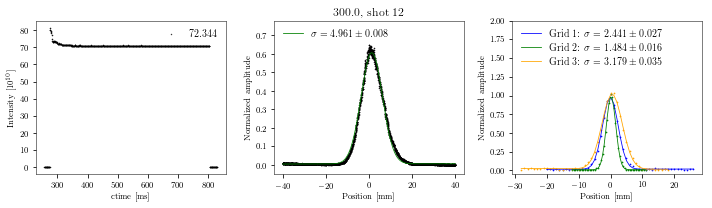

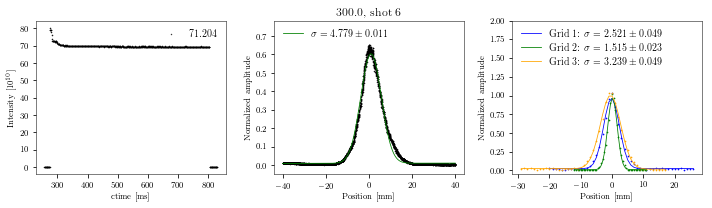

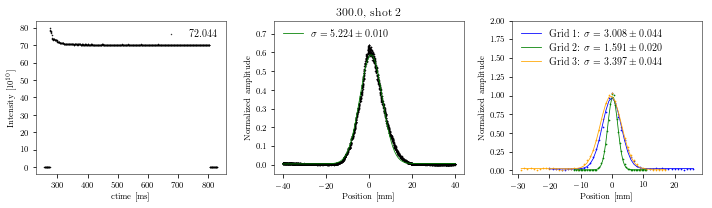

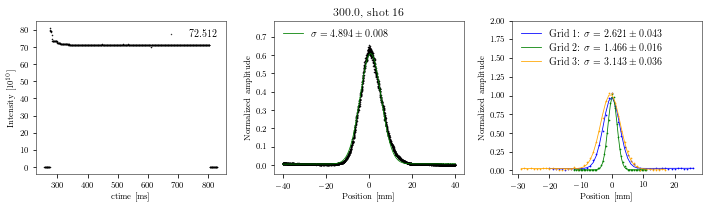

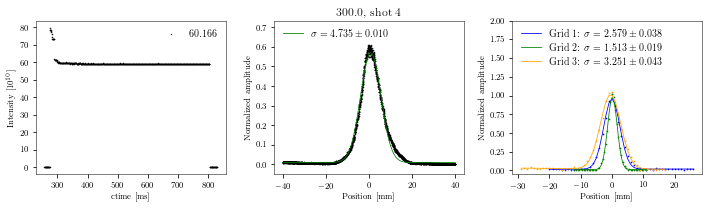

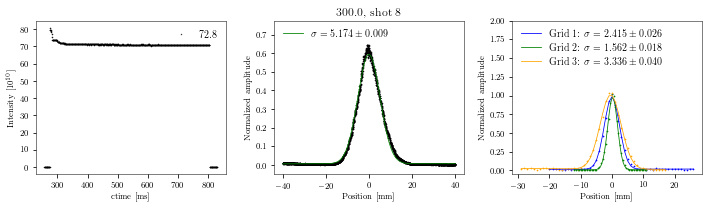

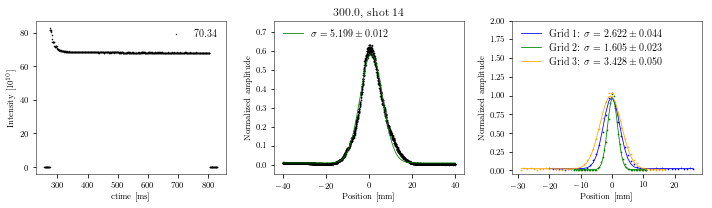

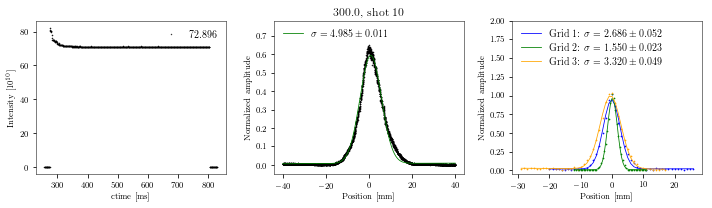

Recorded intensities: [ 72.344  71.204  72.044  72.512  60.166  72.8    70.34   72.896]
Intensities after outlier exclusion: [72.344000000000008, 71.204000000000008, 72.043999999999997, 72.512, 0, 72.799999999999997, 70.340000000000003, 72.896000000000001]
Beta wire: 3.92172965515
Beta rel: 0.34446 Gamma rel: 1.06519
>>> SEMGRID emittance [ 0.50617495  0.53203618  0.64772014  0.52838257  0.54248194  0.5319733
  0.58805576  0.57609473]
2.14029512821 72.344
1.98566503972 71.204
2.37246873743 72.044
2.0825235133 72.512
1.94963240395 0
An intensity value was excluded.
2.32764906875 72.8
2.34973206282 70.34
2.16022337566 72.896

Normal emittance: [ 2.14029513  1.98566504  2.37246874  2.08252351  1.9496324   2.32764907
  2.34973206  2.16022338] 2.17102366623 0.15383164591
Normalized emittance: [1.8643708979609728, 1.7573682186501651, 2.0752185978149789, 1.8098442395665737, 2.0148712251375755, 2.1051214141126686, 1.8674807475767199] 1.92775362012 0.126139790248
Intensity: [ 72.344  71.204  72

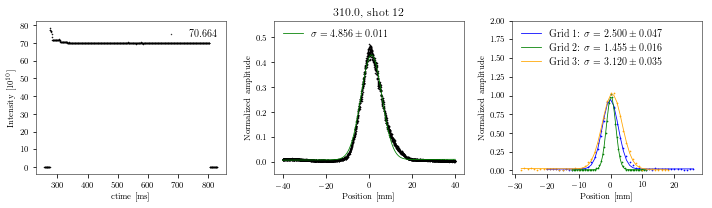

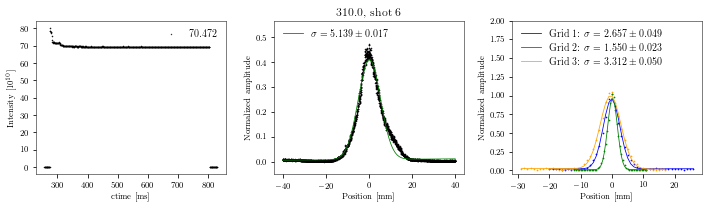

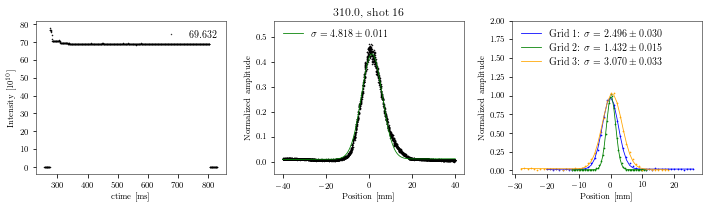

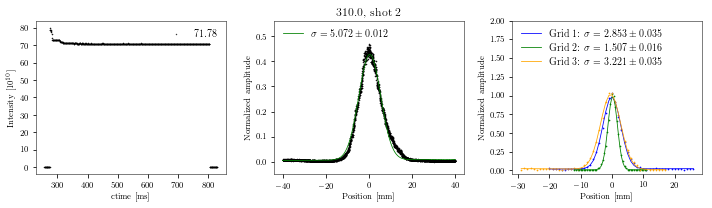

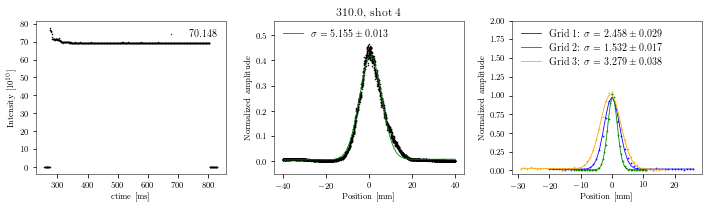

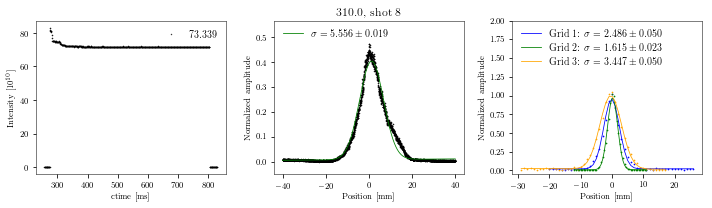

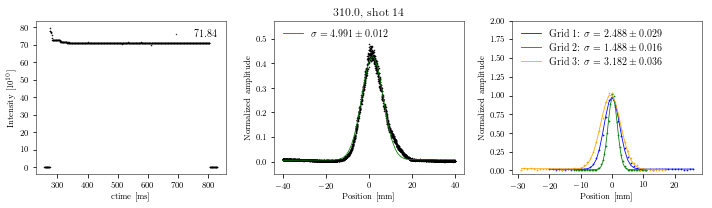

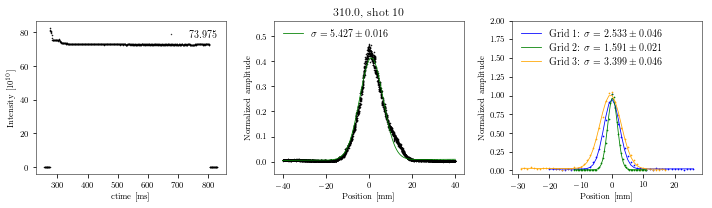

Recorded intensities: [ 70.664  70.472  69.632  71.78   70.148  73.339  71.84   73.975]
Intensities after outlier exclusion: [70.664000000000001, 70.472000000000008, 0, 71.780000000000001, 70.147999999999996, 0, 71.840000000000003, 0]
Beta wire: 3.92011113025
Beta rel: 0.35976 Gamma rel: 1.07176
>>> SEMGRID emittance [ 0.5300949   0.5993053   0.51916875  0.611747    0.55524042  0.59502921
  0.54179209  0.5943489 ]
2.15497417669 70.664
2.41281183994 70.472
2.12121516456 0
An intensity value was excluded.
2.35024638477 71.78
2.42767664854 70.148
2.82008788996 0
An intensity value was excluded.
2.27567941333 71.84
2.69069648728 0
An intensity value was excluded.

Normal emittance: [ 2.15497418  2.41281184  2.12121516  2.35024638  2.42767665  2.82008789
  2.27567941  2.69069649] 2.40667350063 0.228375186727
Normalized emittance: [1.3528970819693098, 1.5188950456256498, 1.4525491831629784, 1.535311329748253, 1.4052890564253491] 1.45298833939 0.068431634401
Intensity: [ 70.664  70.472  69.63

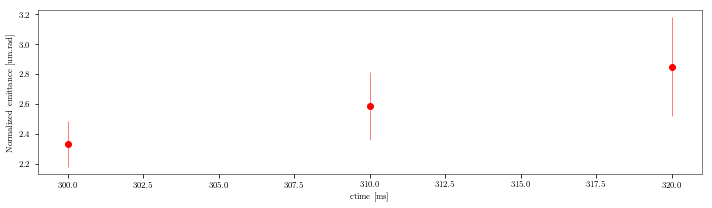

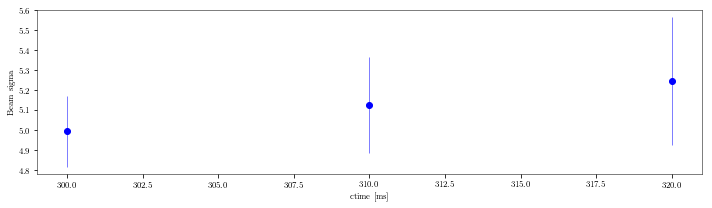

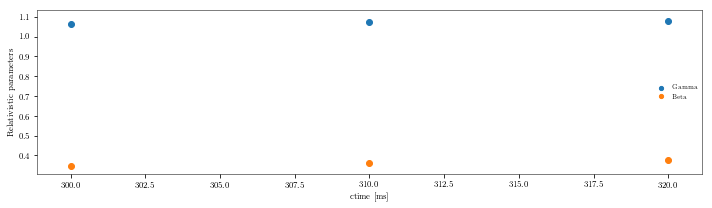

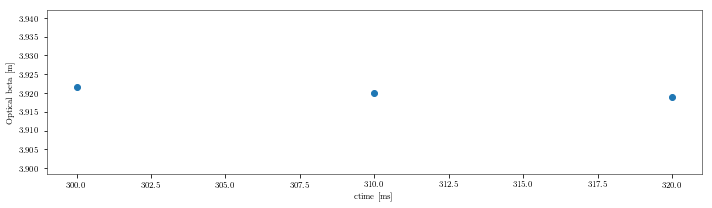

In [14]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('PROFILE_(.*)_V', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

# plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue")
plt.errorbar(ctime, (np.asarray(sigma)**2/np.asarray(beta_wire))*np.asarray(gamma_rel)*np.asarray(beta_rel), yerr=error, fmt='o', color="red")
# plt.scatter(ctime, (np.asarray(sigma)**2/4.22)*np.asarray(gamma_rel)*np.asarray(beta_rel), color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
# plt.xlim([280, 600])
# plt.title("Normalized to intensity")
plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)
plt.show()
plt.clf()

plt.errorbar(ctime, sigma, yerr=sigma_err, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Beam sigma")
# plt.xlim([280, 600])
plt.show()
plt.clf()


# plt.scatter(ctime, (np.asarray(sigma)**2/np.asarray(beta_wire))*np.asarray(gamma_rel)*np.asarray(beta_rel), color="red")
# plt.scatter(ctime, (np.asarray(sigma)**2/4.22)*np.asarray(gamma_rel)*np.asarray(beta_rel), color="orange")
# plt.xlabel("ctime [ms]")
# plt.ylabel("Normalized emittance [um.rad]")
# plt.xlim([280, 320])
# # plt.title("Normalized to intensity")
# plt.show()
# plt.clf()

# plt.errorbar(ctime, sigma, yerr=sigma_err, fmt='o', color="blue")
# plt.xlabel("ctime [ms]")
# plt.ylabel("Beam sigma")
# plt.xlim([280, 320])
# plt.show()
# plt.clf()

plt.scatter(ctime, gamma_rel, label="Gamma")
plt.scatter(ctime, beta_rel, label="Beta")
plt.xlabel("ctime [ms]")
plt.ylabel("Relativistic parameters")
plt.legend()
plt.show()
plt.clf()

plt.scatter(ctime, beta_wire)
plt.xlabel("ctime [ms]")
plt.ylabel("Optical beta [m]")
plt.show()
plt.clf()

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.